<div class="alert alert-block alert-info">

<b>Thank you for contributing to TeachOpenCADD!</b>

</div>

<div class="alert alert-block alert-info">

<b>Set up your PR</b>: Please check out our <a href="https://github.com/volkamerlab/teachopencadd/issues/41">issue</a> on how to set up a PR for new talktorials, including standard checks and TODOs.

</div>

# T034 · SMILES based property prediction

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Azat Tagirdzhanov, 2022, Saarland University

## Aim of this talktorial

Molecular representation by a SMILES string paved the way for applying natural language processing techniques to a broad range of molecule related tasks. In this talktorial we will dive deeper into one of these techinques: recurrent neural networks (RNNs). First, we will describe different RNN architectures and then apply them to a regression task using the QM9 dataset.

### Contents in *Theory*

* Molecules as text
    * Tokenization and one-hot encoding
* Recurrent Neural Networks (RNNs)
    * Vanilla RNN
    * Training an RNN
    * Vanishing gradients
    * Gated Recurrent Unit

### Contents in *Practical*

* Connect to ChEMBL database
* Load and draw molecules

### References

#### Talktorials
* [__Talktorial T021__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T021_one_hot_encoding/talktorial.ipynb): One-Hot Encoding
* [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb): Ligand-based screening: neural networks
* [__Talktorial T033__](todo)(**todo**)
* [__Talktorial T034__](todo)(**todo**)


#### Theoretical background
* Michael Phi, <i>Illustrated Guide to Recurrent Neural Networks</i>, [towardsdatascience](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9)
* Michael Phi, <i>Illustrated Guide to LSTM’s and GRU’s: A step by step explanation</i>, [towardsdatascience](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
* [Modern Recurrent Neural Networks](https://d2l.ai/chapter_recurrent-modern/index.html), <i>D2L.ai: Interactive Deep Learning Book with Multi-Framework Code, Math, and Discussions</i>
* Denny Britz, <i>Recurrent Neural Networks Tutorial</i>, [dennybritz.com](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-1/)
* Andrej Karpathy, <i>The Unreasonable Effectiveness of Recurrent Neural Networks</i>, [Andrej Karpathy blog](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Anvita Gupta, et al. "Generative recurrent networks for de novo drug design." [<i>Molecular informatics</i> <b>37</b>, no. 1-2 (2018)](https://doi.org/10.1002/minf.201700111)


## Theory

### Molecules as text

To apply machine learning to molecular data, it is necesarry to first convert the molecules into a representation that can be used as input to the machine learning models. We have already discussed numerous ways of molecular representations in [__Talktorial T033__](todo)(**todo**). In this talktorial we will be using a textual representation of molecules by SMILES strings.

The string representation of molecules paves the way for applying natural language processing (NLP) techniques to molecular data. In recent years, there has been a significant progress in NLP models including, most famously, recurrent neural networks and transformers. These models proved to be good in capturing text semantics and, when appplied to SMILES strings, can capture the structure of the molecule in its text representation.

#### Tokenization and one-hot encoding

As other machine learning models, NLP models are designed to operate with numeric inputs. We have already discussed how to transform SMILES strings into numerical form in [__Talktorial T021__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T021_one_hot_encoding/talktorial.ipynb). Here, we will only briefly go through the key steps:

- In order to transform a string to a sequence of vectors, the string is first split into meaningful chunks called *tokens*. For example, one way of tokenizing a SMILES string `C=CCl` is to split it into individual atomic and branch symbols: `[C, =, C, Cl]`. 
- All possible tokens form a *vocabulary*. In our example, only limited to this particular compound, the vocabulary will look like `[C, Cl, =]`. Replacing the tokens with their indices in the vocabulary gets us to another representation, `[0, 2, 0, 1]`. 
- Finally, the sequence of token indices is transformed to a sequence of binary vectors using one-hot encoding:
$$
\begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix},~
\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix},~
\begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix},~
\begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}.
$$



### Recurrent Neural Networks (RNNs)

Some basic intuition shared by all rnns:
- RNNs process the input in a sequential manner. 
- they have hidden state that allows passing information about previous timesteps to the coming ones
- they have recurrent connection that feeds previous hidden state to the cell
- can be organized as layers
- rnn tasks

Recurrent neural networks (RNNs) are designed to handle sequential data. To do so, they introduce the notion of time. Elements of the input sequence are processed one after another, with output of the current time step being passed to the next one as an additonal input. This is done by introducing a special type of connection called a *recurrent connection* (hence the name). This architecture allows RNNs to accumulate information about the past and as a result capture dependencies between elements in the sequence.

![RNN](images/rnn-unfolded-800.png)

*Figure 1:* 
Two ways of representing a recurrent neural network: compressed (left) and unfolded in time (right). 

As many other neural networks, RNN cells can be organized in layers. An example of a multi-layer RNN is shown on the Figure 2 below.  

![RNN](images/rnn-multilayer-800.png)

*Figure 2:* 
Multi-layer RNN architecture (unfolded). Hidden states from the first layer are passed as inputs to the second layer.

#### Vanilla RNN
An RNN takes as input a sequence of vectors $x_1, x_2, \dots, x_L$. We will refer to indices of these vectors as *time steps*, with $x_t$ being an input at time step $t$. An RNN cell has a hidden state vector $h_t$ which is updated at each time step and is responsible for aggregating the information about the previous elements of the input sequence. The update is performed combining the input $x_t$ with the hidden state of the previous step $h_{t-1}$
according to the following recurrence relation,

$$h_{t} = \tanh( W x_{t} + U h_{t-1} + b),~~~t=1,2,\dots,L.$$

Here $W$ and $U$ are weight matrices, and $b$ is a bias vector. The initial hidden state $h_0$ is usually seeded as a vector of zeros. It is important to note that the weights $W$, $U$ and $b$ are are shared between all the time steps.

#### Training an RNN
Similar to other neural networks, RNNs are trained using a backpropagation algorithm. A flavour of the algorithm used in RNNs is called *backpropagation through time* or BPTT for short. BPTT unfolds the RNN in time, with every copy of the RNN cell sharing the same weights. Unfolded RNN doesn't have recurrent connections anymore and can be viewed as a normal feed-forward network. The backpropagation algorithm is applied to the unfolded network to compute the gradient of the loss function with respect to the network weights.

#### Vanishing gradients

Vanilla RNNs are susceptible to a problem called *vanishing gradients*. This problem occurs in deep neural networks when the gradients of the weights of the first layers of the network become very small as they are backpropagated through the network. This can lead to slow training and poor performance. In RNNs, the backpropagation is applied to the unfolded network which tends to be very deep. Furthermore, all copies of the RNN cells in the unfolded network share the same weights, which can cause gradients to diminish exponentially fast. For more details on the vanishing gradients problem, please refer to the blogpost [Backpropagation Through Time and Vanishing Gradients](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-3/)

#### Gated Recurrent Unit

Gated recurrent unit (GRU) is a more advanced architecture of the recurrent network that aims to solve the vanishing gradient problem. In addition to the hidden state vector, GRU introduces so-called *update gate* and *reset gate*. These two vectors help the model to decide which information should be passed forward. They can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.



![GRU](images/gru-3.png)

*Figure 3:* 
Gated recurrent unit.
Figure is adapted from ["*<i>D2L.ai: Interactive Deep Learning Book with Multi-Framework Code, Math, and Discussions</i>*"](https://d2l.ai/chapter_recurrent-modern/gru.html).



##### Reset gate

This gate is used by the GRU cell to decide how much of the past information to forget. It is calculated using the formula

$$r_t = \sigma(W_{r} x_t + U_{r} h_{t-1} + b_r).$$

The input vector $x_t$ is multiplied by the weight matrix $W_r$. The hidden state from the previous time step $h_{t-1}$ is also plugged into the cell and is multiplied by its own weight matrix $U_r$. Both results are added together with a bias vector $b_r$, and passed through a sigmoid activation function to limit the output to a range between 0 and 1.

##### Update gate

The update gate is calculated using a similar formula,

$$z_t = \sigma(W_{z} x_t + U_{z} h_{t-1} + b_z),$$

but it has its own weights $W_z$, $U_z$, $b_z$, and serves a different purpose. As we will see below, the update gate helps the GRU cell to decide how much of the past information should be passed to the future step.

##### Hidden state candidate

A candidate hidden state stores the relevant information from the past. It is calculated as follows:

$$\hat{h}_t = \tanh(W_{h} x_t + U_{h}(r_t \odot h_{t-1}) + b_h),$$

where $\odot$ is the [element-wise product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) and $r_t$ is the reset gate vector introduced above. This formula looks similar to how the hidden state is updated in a simple RNN cell, but here the hidden state from the previous time step $h_{t-1}$ is multiplied by the reset gate vector $r_t$. Due to sigmoid activation, components of $r_t$ take values between 0 and 1. Using the reset gate the model can learn which information is not relevant and should be discarded. If, for example, an $i$-th component of $r_t$ is close to 0, then the memory contained in the $i$-th component of $h_{t-1}$ will be discarded in the candidate vector. 

##### Hidden state update

Finally, the hidden state is updated as a mixture of $h_{t-1}$ and the hidden state candidate,

$$h_t =   z_t \odot h_{t-1} + (1-z_t) \odot  \hat{h}_t. $$

Here, the update gate vector $z_t$ controls how much of information to collect from the candidate vector $\hat{h}_t$ and and how much from the previous steps $h_{t-1}$.



## Practical

In the practical section we will apply recurrent neural networks to a regression task.  

In [1]:
from pathlib import Path
import os
import re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# seed random generator
_ = torch.manual_seed(42)

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Dataset

In this talktorial we use [QM9](https://pytorch-geometric.readthedocs.io/en/2.2.0/modules/datasets.html#torch_geometric.datasets.QM9) dataset from the [MoleculeNet](https://arxiv.org/abs/1703.00564) paper. This dataset consists of about 130,000 molecules together with their quantum chemical properties. In this talktorial we will build a model predicting the dipole moment `mu`. 

In [4]:
# load dataset
df = pd.read_csv(os.path.join(DATA, 'qm9.csv.gz'), compression='gzip')

In [5]:
sample_size = 50000

df = df.sample(n=sample_size, axis=0, random_state=42)

df.head()

,mol_id,A,B,C,mu,alpha,homo,lumo,gap,r2,...,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom,smiles
65977,gdb_66703,3.20045,1.74370,1.44173,2.4186,64.08,-0.2371,-0.0296,0.2075,882.3655,...,-436.625775,-436.619353,-436.618409,-436.656379,26.101,-1462.572249,-1470.985890,-1478.689818,-1365.384910,O=C1[C@H]2[C@@H]3[N@H+]2[C@@H]2[C@H]1[C@]32O
25969,gdb_26191,3.77339,1.00579,0.81923,0.7062,80.07,-0.1738,0.0423,0.2161,1397.2819,...,-419.238513,-419.229068,-419.228123,-419.272736,35.677,-1834.114681,-1845.074125,-1855.742406,-1705.718809,C[C@@H](O)c1cc(N)c[nH]1
50853,gdb_51408,5.97141,0.93938,0.91642,2.2882,64.41,-0.2709,-0.0278,0.2431,1213.2519,...,-473.769065,-473.761515,-473.760570,-473.801828,27.241,-1415.812161,-1423.517344,-1431.220645,-1319.723591,O=CO[C@@H]1[C@@H]2N[C@H]1C2=O
60785,gdb_61444,3.22067,0.92106,0.82622,1.4271,71.92,-0.2493,-0.0187,0.2306,1448.5037,...,-460.159223,-460.149407,-460.148463,-460.195052,34.990,-1808.558749,-1819.285388,-1829.954296,-1681.274824,CC(=O)C[C@@H](O)[C@H]1CO1
89539,gdb_90638,3.73721,1.08935,1.01314,3.2559,78.64,-0.2372,0.0214,0.2585,1226.4068,...,-398.096148,-398.087504,-398.086560,-398.129062,33.007,-1732.851043,-1743.424570,-1753.500482,-1610.267160,C[C@H]1N[C@H]2[C@@H]1[C@]2(N)C#N


#### Tokenization

In [7]:
# This tokenizer is adapted from https://github.com/deepchem/deepchem/blob/master/deepchem/feat/smiles_tokenizer.py
class BasicSmilesTokenizer(object):
    def __init__(self):
        self.regex_pattern = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
        self.regex = re.compile(self.regex_pattern)        
    
    def tokenize(self, smiles):
        tokens = [token for token in self.regex.findall(smiles)]
        return tokens

In [8]:
tokenizer = BasicSmilesTokenizer()
print(' '.join(tokenizer.tokenize('CCOc1ccc2nc(S(N)(=O)=O)sc2c1')))

C C O c 1 c c c 2 n c ( S ( N ) ( = O ) = O ) s c 2 c 1


In [9]:
tokenized_smiles = [tokenizer.tokenize(s) for s in df['smiles']]
tokens = Counter(c for s in tokenized_smiles for c in s)

tokens.most_common(30)

[('C', 196880),
 ('1', 96426),
 ('O', 66869),
 ('2', 48720),
 ('(', 44049),
 (')', 44049),
 ('[C@H]', 43037),
 ('=', 30497),
 ('[C@@H]', 29039),
 ('c', 26996),
 ('N', 26979),
 ('#', 13961),
 ('3', 12690),
 ('n', 10839),
 ('[C@]', 9456),
 ('[C@@]', 8877),
 ('[NH-]', 3395),
 ('o', 3101),
 ('[nH]', 2914),
 ('[N@H+]', 2875),
 ('/', 2126),
 ('[N@@H+]', 2102),
 ('[NH2+]', 1846),
 ('4', 1744),
 ('[CH+]', 1468),
 ('F', 1256),
 ('[NH+]', 629),
 ('[H]', 619),
 ('\\', 566),
 ('[nH+]', 492)]

In [10]:
seq_len = max([len(toks) for toks in tokenized_smiles])
vocab_size = 30

vocab   = [tok for tok,_ in tokens.most_common(vocab_size)] 
token_to_index = {t:i for i,t in enumerate(vocab)}

#### One hot encoding

In [11]:
X = np.zeros((len(tokenized_smiles), seq_len, vocab_size))
for i, tokens in enumerate(tokenized_smiles):
    for k, token in enumerate(tokens):
        n = token_to_index.get(token, vocab_size-1)
        X[i, k, n] = 1

X.shape

(50000, 27, 30)

In [12]:
y = df['mu'].to_numpy()
y = (y - y.mean()) / y.std()

In [13]:
train_batch_size = 64   
n_test = n_val = 5000
n_train = 40000

dataset = TensorDataset(torch.Tensor(X), torch.Tensor(y))

data_train, data_val, data_test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))    

train_loader = DataLoader(data_train, batch_size=train_batch_size, shuffle=True, generator=torch.Generator().manual_seed(42)) 
val_loader = DataLoader(data_val, batch_size=1, shuffle=True, generator=torch.Generator().manual_seed(42)) 
test_loader = DataLoader(data_test, batch_size=1, shuffle=True, generator=torch.Generator().manual_seed(42))

### Models

In [14]:
class RNNRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(RNNRegressionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=.2)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, hn = self.rnn(x, h0)
        out = out[:, -1]
        out = self.dropout(out)
        out = self.fc(out)
        return out
    
    
class GRURegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(GRURegressionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) 
        self.fc = nn.Linear(hidden_size, 1)  
        self.dropout = nn.Dropout(p=.2)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, hn = self.gru(x, h0)
        out = out[:, -1]
        out = self.dropout(out)
        out = self.fc(out)
        return out

### Training

In [15]:
def train_model(model, criterion, optimizer, loader, clip_gradients=False):
    model.train()
    epoch_loss = 0
    batch_losses = []
    
    for i, (X_batch, y_batch) in enumerate(loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        
        if clip_gradients:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2)
        
        optimizer.step()
        epoch_loss += loss.item()
        batch_losses.append(loss.item())

    return epoch_loss/len(loader), batch_losses

 
def eval_model(model, criterion, loader):   
    model.eval()
    test_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            test_loss += loss.item()
            predictions.append(y_pred.detach().numpy())
            targets.append(y_batch.unsqueeze(1).detach().numpy())

    predictions = np.concatenate(predictions).flatten()
    targets = np.concatenate(targets).flatten()
    
    return test_loss/len(loader), predictions, targets

In [16]:
class ModelTrainer(object):
    def __init__(self, model, lr, name=None, clip_gradients=False):
        self.model = model
        self.lr = lr
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        self.clip_gradients = clip_gradients
        self.model.to(device)
        
        self.train_loss = []
        self.batch_loss = []
        self.test_loss  = []
    
    def _train_epoch(self, loader):
        self.model.train()
        epoch_loss = 0
        batch_losses = []
        for i, (X_batch, y_batch) in enumerate(loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            self.optimizer.zero_grad()
            y_pred = self.model(X_batch)
            loss = self.criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            
            if self.clip_gradients:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
            
            self.optimizer.step()
            epoch_loss += loss.item()
            batch_losses.append(loss.item())
        
        return epoch_loss/len(loader), batch_losses
    
    def _eval_epoch(self, loader):
        self.model.eval()
        test_loss = 0
        predictions = []
        targets = []
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = self.model(X_batch)
                loss = self.criterion(y_pred, y_batch.unsqueeze(1))
                test_loss += loss.item()
                predictions.append(y_pred.detach().numpy())
                targets.append(y_batch.unsqueeze(1).detach().numpy())
        
        predictions = np.concatenate(predictions).flatten()
        targets = np.concatenate(targets).flatten()
        return test_loss/len(loader), predictions, targets
    
    def train(self, train_loader, test_loader, n_epochs, print_every=10):
        for e in range(n_epochs):
            train_loss, train_loss_batches = self._train_epoch(train_loader)
            test_loss, _, _ = self._eval_epoch(test_loader)
            self.batch_loss += train_loss_batches
            self.train_loss.append(train_loss)
            self.test_loss.append(test_loss)
            if e % print_every == 0:
                print(f'Epoch {e+0:03} | train_loss: {train_loss:.5f} | test_loss: {test_loss:.5f}')
    
    def validate(self, val_loader):
        loss, y_pred, y_targ = self._eval_epoch(val_loader)
        return loss, y_pred, y_targ

In [17]:
input_size = X.shape[2]
learning_rate = 1e-3

model_rnn = ModelTrainer(
    model=RNNRegressionModel(input_size),
    lr=learning_rate,
)

In [18]:
model_rnn.train(train_loader, test_loader, 51)

Epoch 000 | train_loss: 0.97890 | test_loss: 0.89825
Epoch 010 | train_loss: 0.58709 | test_loss: 0.58682
Epoch 020 | train_loss: 0.52529 | test_loss: 0.53558
Epoch 030 | train_loss: 0.50315 | test_loss: 0.51534
Epoch 040 | train_loss: 0.48645 | test_loss: 0.49958
Epoch 050 | train_loss: 0.48438 | test_loss: 0.49776


In [21]:
learning_rate = 1e-3

model_gru = ModelTrainer(
    model=GRURegressionModel(input_size),
    lr=learning_rate,
)

In [22]:
model_gru.train(train_loader, test_loader, 51)

Epoch 000 | train_loss: 0.75178 | test_loss: 0.59978
Epoch 010 | train_loss: 0.44454 | test_loss: 0.41863
Epoch 020 | train_loss: 0.38213 | test_loss: 0.39115
Epoch 030 | train_loss: 0.34844 | test_loss: 0.35323
Epoch 040 | train_loss: 0.32392 | test_loss: 0.33633
Epoch 050 | train_loss: 0.30527 | test_loss: 0.32454


### Evaluation

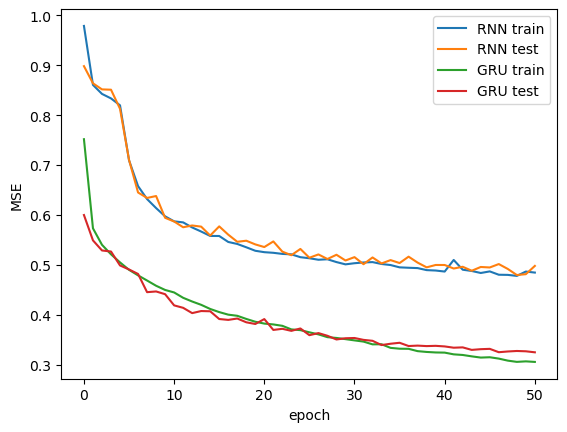

In [23]:

_ = plt.plot(model_rnn.train_loss, label=f'RNN train')
_ = plt.plot(model_rnn.test_loss, label=f'RNN test')
_ = plt.plot(model_gru.train_loss, label=f'RNN train')
_ = plt.plot(model_gru.test_loss, label=f'RNN test')
_ = plt.xlabel('epoch')
_ = plt.ylabel('MSE')
_ = plt.legend()

RNN Validation loss: 0.523
GRU Validation loss: 0.338


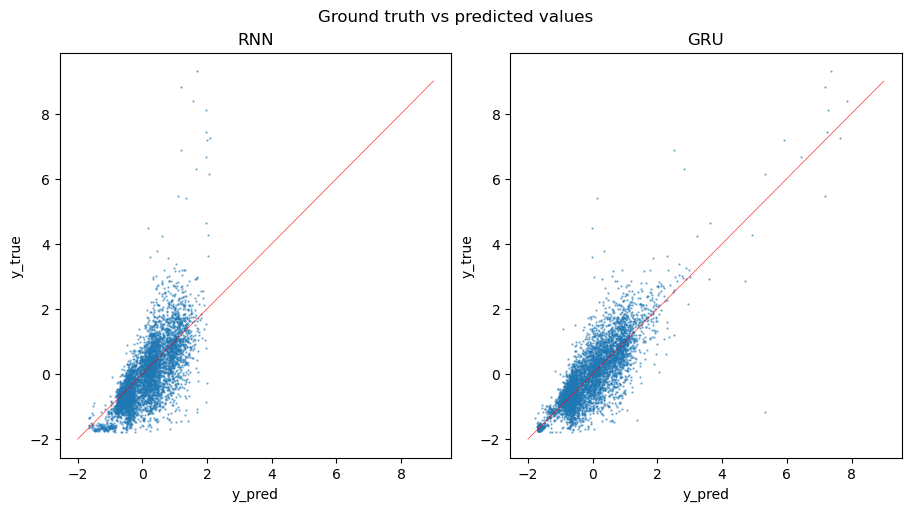

In [24]:
f, axarr = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

f.suptitle('Ground truth vs predicted values')

loss, y_pred, y_targ = model_rnn.validate(val_loader)
print(f'RNN Validation loss: {loss:.3f}')

_ = axarr[0].scatter(y_pred, y_targ, alpha=.5, s=.5)
_ = axarr[0].plot([-2,9],[-2,9], lw=.4, c='r')
_ = axarr[0].set_title('RNN')

loss, y_pred, y_targ = model_gru.validate(val_loader)
print(f'GRU Validation loss: {loss:.3f}')

_ = axarr[1].scatter(y_pred, y_targ, alpha=.5, s=.5)
_ = axarr[1].plot([-2,9],[-2,9], lw=.4, c='r')
_ = axarr[1].set_title('GRU')

for ax in axarr:
    _ = ax.set_xlabel('y_pred')
    _ = ax.set_ylabel('y_true')

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Another approach to handling sequential data would be to concatenate the input sequence into one vector and use it as an input to a feed-forward network. What benefits do RNNs have compared to this approach?
2. Question
3. Question

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># NBVAL_CHECK_OUTPUT</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>